In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import cv2
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
# from tensorflow.python.keras import get_activations, display_activations


2023-04-07 11:19:41.010002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 11:19:46.096945: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-07 11:19:46.096967: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-07 11:19:53.613604: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
def read_data(path):
    
    train_path = path+"/train"
    test_path = path+"/test"
    validation_path = path+"/val"
    
    tr_data, test_data, val_data = [], [], []
    tr_out, test_out, val_out = [], [], []
    labels=[]
    for i in os.listdir(train_path):
        labels.append(int(i))

        if i != ".DS_Store":
            for j in os.listdir(train_path+"/"+i):
                tr_data.append(cv2.imread(train_path+"/"+i+"/"+j, cv2.IMREAD_GRAYSCALE))
                tr_out.append(i)

            for j in os.listdir(test_path+"/"+i):
                test_data.append(cv2.imread(test_path+"/"+i+"/"+j, cv2.IMREAD_GRAYSCALE))
                test_out.append(i)

            for j in os.listdir(validation_path+"/"+i):
                val_data.append(cv2.imread(validation_path+"/"+i+"/"+j, cv2.IMREAD_GRAYSCALE))
                val_out.append(i)
                
                
    tr_data, test_data, val_data = np.array(tr_data), np.array(test_data), np.array(val_data)
    tr_out, test_out, val_out = np.array(list(map(int, tr_out))), np.array(list(map(int, test_out))), np.array(list(map(int, val_out)))

    return tr_data, test_data, val_data, tr_out, test_out, val_out, labels

In [3]:
path = "/home/urvashi/Downloads/Group_5"
tr_data, test_data, val_data, tr_out, test_out, val_out,labels = read_data(path)
labels.sort()

In [4]:
def convert_labels(d):
    op=d
    for i in range(len(d)):
        if op[i] == 4:
            op[i]=3
        elif op[i] == 7:
            op[i]=4
    return op

In [5]:
train_out=convert_labels(tr_out)
val_out=convert_labels(val_out)
test_out=convert_labels(test_out)
train_out.shape

(11385,)

In [6]:
def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array

In [7]:
def noise(array , nf):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = nf
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

In [8]:
def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 5

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [9]:
train_data  = preprocess(tr_data)
val_data  = preprocess(val_data)
test_data = preprocess(test_data)
test_data.shape

(3795, 28, 28, 1)

In [10]:
noisy_train_data = noise(train_data,0.2)
noisy_val_data = noise(val_data,0.2)
noisy_test_data = noise(test_data,0.2)
noisy_test_data.shape

(3795, 28, 28, 1)

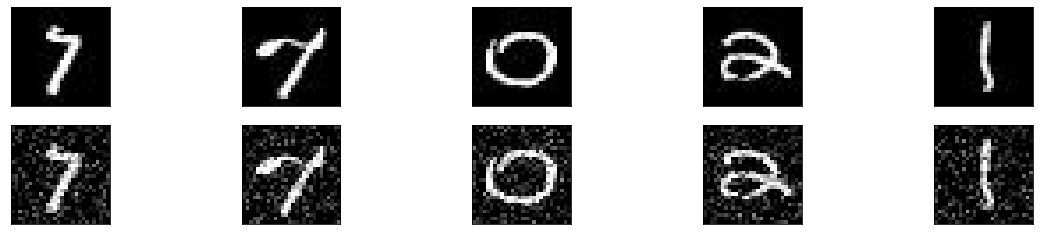

In [11]:
display(test_data, noisy_test_data)

In [95]:
class NoisyAutoencoder(tf.keras.models.Model):
     
    def __init__(self):
           
        super(NoisyAutoencoder, self).__init__()
        self.n=n
        self.encoder = tf.keras.Sequential([
          tf.keras.layers.Flatten(input_shape=(28, 28), name='Input_Layer'),
          tf.keras.layers.Dense(32, activation='sigmoid', name='Hidden_Layer_1')])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(784, activation='sigmoid', name='Output_Layer'),
            tf.keras.layers.Reshape((28, 28))])
          

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

noisyautoenoder = NoisyAutoencoder()



In [96]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, name='Adam')
noisyautoenoder.compile(optimizer=optimizer, loss='mse')

In [97]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.0001,patience=2)
trained = noisyautoenoder.fit(noisy_train_data, train_data, epochs=10000,callbacks=callback)

Epoch 1/10000
356/356 [==============================] - 1s 1ms/step - loss: 0.0785
Epoch 2/10000
356/356 [==============================] - 0s 1ms/step - loss: 0.0658
Epoch 3/10000
356/356 [==============================] - 0s 1ms/step - loss: 0.0656
Epoch 4/10000
356/356 [==============================] - 0s 1ms/step - loss: 0.0655
Epoch 5/10000
356/356 [==============================] - 0s 1ms/step - loss: 0.0655


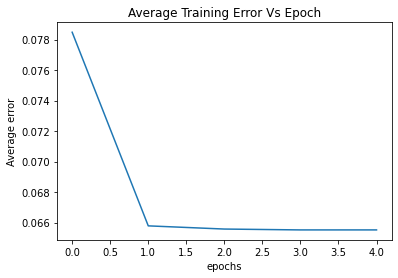

In [98]:
#Plotting error vs epoch graph
plt.plot(trained.history['loss'])
plt.title("Average Training Error Vs Epoch")
plt.xlabel("epochs")
plt.ylabel("Average error")
plt.show()

In [99]:
recon_error_train = noisyautoenoder.evaluate(noisy_train_data,train_data)
recon_error_val = noisyautoenoder.evaluate(noisy_val_data,val_data)
recon_error_test = noisyautoenoder.evaluate(noisy_test_data,test_data)

119/119 [==============================] - 0s 933us/step - loss: 0.0657


In [100]:
encoded_imgs = noisyautoenoder.encoder(noisy_test_data).numpy()
decoded_imgs = noisyautoenoder.decoder(encoded_imgs).numpy()
encoded_imgs.shape

(3795, 32)

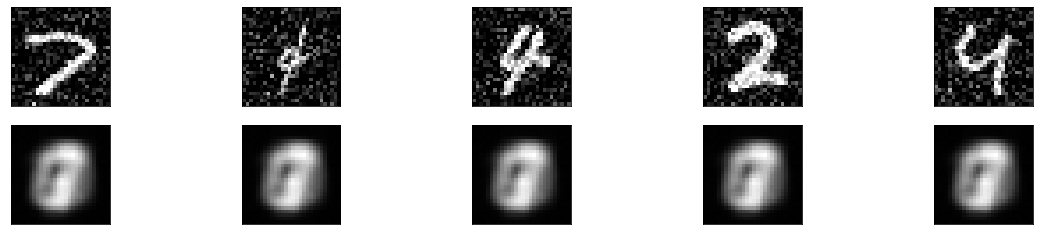

In [101]:
display(noisy_test_data, decoded_imgs)

In [38]:
weight1 = noisyautoenoder.layers[0].get_weights()
weight1[0].shape

(784, 32)

In [40]:
w1 = []

for w in weight1[0].T:
    w1.append(w.reshape(28, 28))
    
w1 = np.array(w1)
w1.shape

(32, 28, 28)

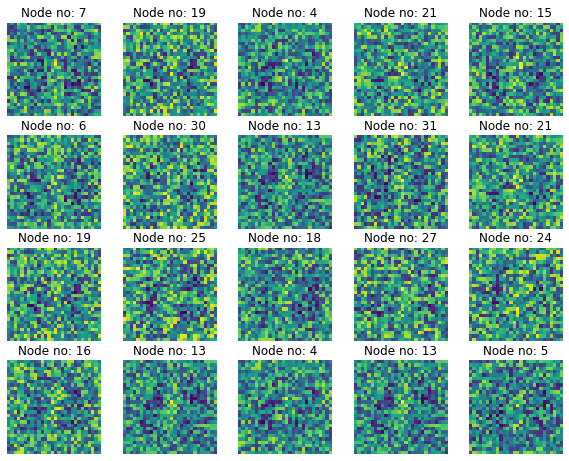

In [42]:
n = 20
plt.figure(figsize=(10, 10))
for i in range(n):
    k = np.random.randint(0, 32)
    ax = plt.subplot(5, 5, i+1)
    plt.title("Node no: "+str(k))
    plt.imshow(w1[k],cmap='viridis')
    plt.axis('off')
plt.show()

In [ ]:
encoded_tr = noisyautoenoder.encoder(noisy_train_data).numpy()
encoded_tr.shape

# 32 Dimension

In [ ]:
# Generating Three Layer FCNN Architecture
model32 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(256,), name='Input_Layer'),    
    tf.keras.layers.Dense(512, activation='sigmoid', name='Hidden_Layer_1'),
    tf.keras.layers.Dense(256, activation='sigmoid', name='Hidden_Layer_2'),
    tf.keras.layers.Dense(256, activation='sigmoid', name='Hidden_Layer_3'),
    tf.keras.layers.Dense(5, activation='softmax', name='Output_Layer')
])

# Printing the architecture details of the model
model32.summary()

In [ ]:
#Setting the optimizer and compiling
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, name='Adam')
model32.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',    metrics=['accuracy'])

# Setting the convergence criteria and fitting the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.0001,patience=2)
trained32 = model32.fit(encoded_tr, train_out, epochs=10000, callbacks=callback)